In [133]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from scipy.stats import norm
#from prophet import Prophet

In [121]:
# Load the data from a CSV file
df = pd.read_csv("../data/pollofpolls.csv", sep=";")

In [123]:
# Ensure the "Mnd" column is treated as a string (optional but recommended)
df["Mnd"] = df["Mnd"].astype(str)

# Create an empty dictionary for the predictions
predictions = {"Mnd": ["Mars-25","April-25","Mai-25","Juni-25","Juli-25","August-25","September-25"]}


In [124]:
month_mapping = {
    "Januar": "January", "Februar": "February", "Mars": "March", "April": "April",
    "Mai": "May", "Juni": "June", "Juli": "July", "August": "August",
    "September": "September", "Oktober": "October", "November": "November", "Desember": "December"
}

# Replace Norwegian months with English
df["Mnd"] = df["Mnd"].replace(month_mapping, regex=True)

# Convert to datetime and set the date to the end of the month
df["Mnd"] = pd.to_datetime(df["Mnd"], format="%B-%y").dt.to_period("M").dt.to_timestamp("M")

# Sort values and set index
df = df.sort_values("Mnd")
df.set_index("Mnd", inplace=True)

#print(df)  # Check that dates are correctly formatted at month-end


In [125]:
# Perform ADF test on each party's time series
for party in ['Ap', 'Hoyre', 'Frp', 'SV', 'Sp', 'KrF', 'Venstre', 'MDG','Rodt', 'Andre']: 
    result = adfuller(df[party])
    print(f"{party} ADF Statistic: {result[0]}, p-value: {result[1]}")
    if result[1] > 0.05:
        print(f"Warning: {party} is not stationary, consider differencing.")

Ap ADF Statistic: -1.7801822589557765, p-value: 0.39034408610867655
Hoyre ADF Statistic: -2.2989231540603043, p-value: 0.17231551097951114
Frp ADF Statistic: -1.582571861819359, p-value: 0.49234205741872633
SV ADF Statistic: -1.160916983088228, p-value: 0.6901783573567423
Sp ADF Statistic: -1.6059394874788055, p-value: 0.48060925134060084
KrF ADF Statistic: -1.8947928921859223, p-value: 0.33451464977124046
Venstre ADF Statistic: -2.8586375025689597, p-value: 0.05037365394503086
MDG ADF Statistic: -1.6159866377465042, p-value: 0.47483396704156744
Rodt ADF Statistic: -0.6134683727205307, p-value: 0.8679095925971021
Andre ADF Statistic: -1.7235826457432835, p-value: 0.4190047711122682


In [126]:
df_diff = df.diff().dropna()  # Difference to make stationary

In [127]:
model = VAR(df_diff)  # Use df_diff if differenced data is needed
#model_fitted = model.fit(45)  # Choose lag order (5 is an example, tune this)
#model.select_order()
#model_fitted = model.fit(maxlags=17, ic='aic', method = 'ols', trend='ctt', verbose=True)
model_fitted = model.fit(5,method = 'ols', trend='n', verbose=True)

# Display the summary of the fitted model
print(model_fitted.summary())
#model_fitted.k_ar

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 07, Mar, 2025
Time:                     14:24:35
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -4.03497
Nobs:                     200.000    HQIC:                  -8.94382
Log likelihood:          -1109.80    FPE:                5.17066e-06
AIC:                     -12.2808    Det(Omega_mle):     5.55195e-07
--------------------------------------------------------------------
Results for equation Ap
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
L1.Ap             -1.372616         0.445164           -3.083           0.002
L1.Hoyre          -1.375933         0.446045           -3.085           0.002
L1.Frp            -1.374523         0.448924           -3.062           0.0

C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


In [128]:
forecast = model_fitted.forecast(df_diff.values[-model_fitted.k_ar:], steps=8)

# Convert forecasted values to a DataFrame
forecast_dates = pd.date_range(start="2025-02-28", periods=8, freq='ME')
forecast_diff_df = pd.DataFrame(forecast, index=forecast_dates, columns=df.columns)

print(forecast_diff_df)

                  Ap     Hoyre       Frp        SV        Sp       KrF  \
2025-02-28  1.132488 -0.414877 -0.930814 -0.324623 -0.063869  0.308339   
2025-03-31 -1.403706  1.257453  0.243681  0.087699 -0.699419  0.203713   
2025-04-30  0.892731 -0.947800 -1.182182  0.749014 -0.270587  0.212477   
2025-05-31  1.541309 -0.636189 -0.351909 -0.353376  0.298794 -0.113390   
2025-06-30  0.759297  0.034754 -0.087660 -0.292282  0.297708 -0.173692   
2025-07-31 -0.170890 -0.257669  0.103281  0.036640  0.037056  0.121075   
2025-08-31 -0.645872 -0.028689  0.117394  0.136348  0.159419  0.076192   
2025-09-30  0.221077  0.047092  0.067764 -0.059919 -0.201446 -0.144516   

             Venstre       MDG      Rodt     Andre  
2025-02-28  0.375978  0.023539 -0.164132  0.286203  
2025-03-31 -0.038161  0.425319 -0.271154  0.172484  
2025-04-30 -0.035578 -0.049710  0.167344  0.070630  
2025-05-31  0.049760 -0.073257 -0.053791 -0.164446  
2025-06-30 -0.277985 -0.252074  0.169130 -0.231706  
2025-07-31  0.1

In [129]:
# Invert differencing (cumulative sum and add back the last observed value)
forecast_original_scale = forecast_diff_df.cumsum() + df.iloc[-1]

In [130]:
forecast_original_scale

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
2025-02-28,25.932488,17.985123,23.669186,7.075377,6.536131,3.308339,4.575978,2.423539,5.235868,3.486203
2025-03-31,24.528782,19.242575,23.912867,7.163076,5.836712,3.512052,4.537817,2.848858,4.964714,3.658687
2025-04-30,25.421513,18.294776,22.730685,7.912090,5.566125,3.724529,4.502240,2.799148,5.132059,3.729317
2025-05-31,26.962822,17.658586,22.378776,7.558713,5.864919,3.611138,4.551999,2.725892,5.078267,3.564870
2025-06-30,27.722119,17.693340,22.291116,7.266431,6.162627,3.437446,4.274014,2.473818,5.247397,3.333164
2025-07-31,27.551229,17.435671,22.394397,7.303071,6.199683,3.558520,4.450245,2.574147,5.112018,3.377391
2025-08-31,26.905357,17.406982,22.511792,7.439419,6.359102,3.634712,4.446734,2.607470,5.042689,3.508710
2025-09-30,27.126435,17.454074,22.579555,7.379500,6.157656,3.490196,4.338427,2.662151,5.189756,3.456102


<Figure size 1200x600 with 0 Axes>

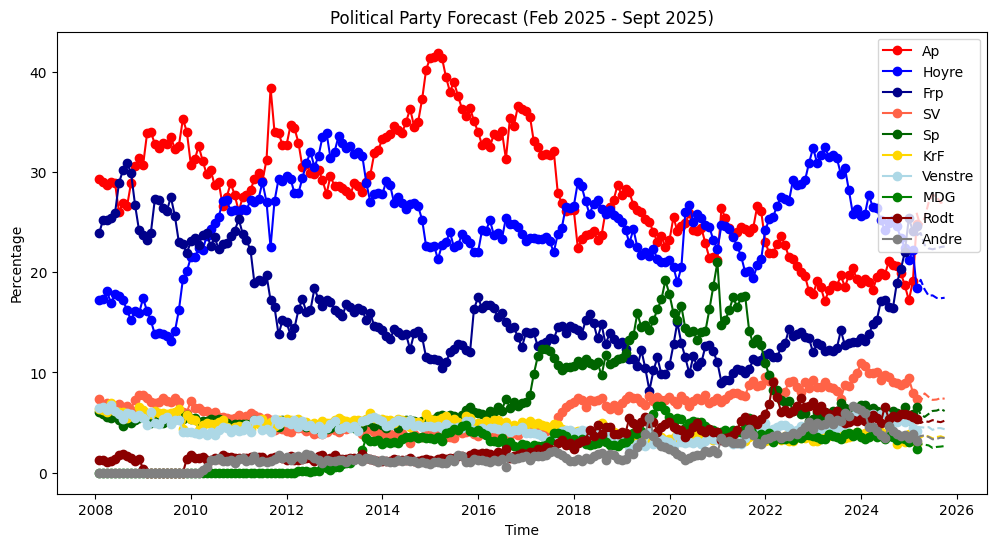

In [131]:
plt.figure(figsize=(12, 6))


# Define a color map for consistency
colors = {
    'Ap': '#FF0000',        # Red
    'Hoyre': '#0000FF',     # Blue
    'Frp': '#00008B',       # Dark Blue
    'SV': '#FF6347',        # Light Red (Tomato)
    'Sp': '#006400',        # Dark Green
    'KrF': '#FFD700',       # Yellow (Gold)
    'Venstre': '#ADD8E6',   # Light Blue
    'MDG': '#008000',       # Green
    'Rodt': '#8B0000',      # Dark Red
    'Andre': '#808080'      # Gray
}


plt.figure(figsize=(12, 6))

for party in ['Ap', 'Hoyre', 'Frp', 'SV', 'Sp', 'KrF', 'Venstre', 'MDG','Rodt', 'Andre']:
    color = colors.get(party, np.random.rand(3,))  # Use predefined color or random if missing
    
    # Plot actual data
    plt.plot(df.index, df[party], marker="o", color=color, label=f"{party}")

    # Plot forecast with the same color
    plt.plot(forecast_original_scale.index, forecast_original_scale[party], linestyle="dashed", color=color)

plt.xlabel("Time")
plt.ylabel("Percentage")
plt.title("Political Party Forecast (Feb 2025 - Sept 2025)")
plt.legend()
plt.show()

In [132]:
forecast_original_scale

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
2025-02-28,25.932488,17.985123,23.669186,7.075377,6.536131,3.308339,4.575978,2.423539,5.235868,3.486203
2025-03-31,24.528782,19.242575,23.912867,7.163076,5.836712,3.512052,4.537817,2.848858,4.964714,3.658687
2025-04-30,25.421513,18.294776,22.730685,7.912090,5.566125,3.724529,4.502240,2.799148,5.132059,3.729317
2025-05-31,26.962822,17.658586,22.378776,7.558713,5.864919,3.611138,4.551999,2.725892,5.078267,3.564870
2025-06-30,27.722119,17.693340,22.291116,7.266431,6.162627,3.437446,4.274014,2.473818,5.247397,3.333164
2025-07-31,27.551229,17.435671,22.394397,7.303071,6.199683,3.558520,4.450245,2.574147,5.112018,3.377391
2025-08-31,26.905357,17.406982,22.511792,7.439419,6.359102,3.634712,4.446734,2.607470,5.042689,3.508710
2025-09-30,27.126435,17.454074,22.579555,7.379500,6.157656,3.490196,4.338427,2.662151,5.189756,3.456102
